# 08 — Recommender

We test 4 configurations side by side:
- Word2Vec, no boost
- Word2Vec, with recency boost
- SBERT-MPNet, no boost
- SBERT-MPNet, with recency boost

**Note:** W2V is retrained on the fly (~10s). SBERT embedding is loaded from file if available, otherwise recomputed (~20min on CPU).

**Metrics:** sector precision, diversity, mean similarity

In [2]:
import sys
sys.path.append('../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import os

from user_profile import SYNTHETIC_USERS
from profile_builder import build_profile_vectors, save_profiles
from recommender import Recommender, evaluate_recommendations
from embeddings import train_word2vec, embed_corpus, load_sbert

df_pool     = pd.read_csv('../data/processed/article_pool.csv')
df_stocks   = pd.read_csv('../data/processed/psx_stocks_clean.csv')
df_cnhpsx   = pd.read_csv('../data/processed/cnhpsx_clean.csv')
df_news     = pd.read_csv('../data/processed/pakistan_news_clean.csv')
reading_log = pd.read_csv('../data/processed/reading_log.csv')

print('Pool:', df_pool.shape)
print('Stocks:', df_stocks.shape)

Pool: (14213, 5)
Stocks: (813588, 10)


## Step 1 — Word2Vec embeddings + profiles
W2V is fast to retrain (~10s) so we do it directly here to avoid numpy compatibility issues with saved files.

In [3]:
# Retrain W2V on the same corpus as notebook 05
w2v_corpus = list(df_cnhpsx['headline_clean'].dropna()) + list(df_news['text_clean'].dropna())
print(f'Training corpus: {len(w2v_corpus)} texts')

w2v_model = train_word2vec(
    texts=w2v_corpus,
    vector_size=100,
    window=5,
    min_count=2,
    epochs=10
)

emb_w2v = embed_corpus(
    texts=list(df_pool['text_for_embedding'].fillna('')),
    method='word2vec',
    model=w2v_model
)
print('W2V pool embeddings:', emb_w2v.shape)

Training corpus: 34770 texts
[Word2Vec] Tokenizing 34770 texts...
[Word2Vec] Training (vector_size=100, window=5, epochs=10)...
[Word2Vec] Vocabulary size: 15243 words
[embed_corpus] Embedding 14213 texts with word2vec...


Word2Vec: 100%|█████████████████████████████████████████████████████████████████| 14213/14213 [00:01<00:00, 7605.24it/s]

[embed_corpus] Done. Shape: (14213, 100)
W2V pool embeddings: (14213, 100)


In [4]:
# Build W2V user profiles
users_w2v = copy.deepcopy(SYNTHETIC_USERS)
for user in users_w2v:
    user.clicked_articles = reading_log[
        reading_log['user_id'] == user.user_id
    ]['article_id'].tolist()

users_w2v = build_profile_vectors(
    users=users_w2v,
    embeddings=emb_w2v,
    df_tagged=df_pool
)
print('W2V profiles built')

[Builder] User_1: vector from 10 articles, dim=100
[Builder] User_2: vector from 10 articles, dim=100
[Builder] User_3: vector from 10 articles, dim=100
[Builder] User_4: vector from 10 articles, dim=100
W2V profiles built


## Step 2 — SBERT embeddings + profiles
SBERT takes ~20min on CPU so we try to load the saved file first.
If it fails (numpy version mismatch), we recompute and save properly. I screw up on the previous notebooks to save the embeddings

In [5]:
SBERT_PATH = '../data/processed/embeddings_pool_sbert_mpnet.npy'

sbert_model = load_sbert('mpnet')
emb_sbert = embed_corpus(
    texts=list(df_pool['headline'].fillna('')),
    method='sbert',
    model=sbert_model
)
np.save(SBERT_PATH, emb_sbert)
print('SBERT embeddings recomputed and saved:', emb_sbert.shape)

[SBERT] Loading: all-mpnet-base-v2...


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

MPNetModel LOAD REPORT from: sentence-transformers/all-mpnet-base-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


[SBERT] Ready — embedding dim: 768
[embed_corpus] Embedding 14213 texts with sbert...


Batches:   0%|          | 0/223 [00:00<?, ?it/s]

[embed_corpus] Done. Shape: (14213, 768)
SBERT embeddings recomputed and saved: (14213, 768)


In [6]:
# Build SBERT user profiles
users_sbert = copy.deepcopy(SYNTHETIC_USERS)
for user in users_sbert:
    user.clicked_articles = reading_log[
        reading_log['user_id'] == user.user_id
    ]['article_id'].tolist()

users_sbert = build_profile_vectors(
    users=users_sbert,
    embeddings=emb_sbert,
    df_tagged=df_pool
)
print('SBERT profiles built')

[Builder] User_1: vector from 10 articles, dim=768
[Builder] User_2: vector from 10 articles, dim=768
[Builder] User_3: vector from 10 articles, dim=768
[Builder] User_4: vector from 10 articles, dim=768
SBERT profiles built


## Step 3 — Set up recommenders

In [7]:
rec_w2v   = Recommender(emb_w2v,   df_pool, df_stocks)
rec_sbert = Recommender(emb_sbert, df_pool, df_stocks)

configs = [
    ('W2V — no boost',        rec_w2v,   users_w2v,   False),
    ('W2V — recency boost',   rec_w2v,   users_w2v,   True),
    ('SBERT — no boost',      rec_sbert, users_sbert, False),
    ('SBERT — recency boost', rec_sbert, users_sbert, True),
]

print('Recommenders ready')

Recommenders ready


## Step 4 — Run all 4 configurations

In [8]:
print(df_stocks.columns.tolist())
print(df_stocks.head(2))

['date', 'symbol', 'ldcp', 'open', 'high', 'low', 'close', 'change', 'change_pct', 'volume']
         date symbol   ldcp  open  high   low  close  change  change_pct  \
0  2018-09-04    786  2.999  3.99  3.99  3.99   3.99   0.991   33.044348   
1  2018-09-05    786  3.990  4.99  4.99  4.99   4.99   1.000   25.062657   

   volume  
0   21000  
1  150500  


In [9]:
import importlib, scorer, recommender
importlib.reload(scorer)
importlib.reload(recommender)
from recommender import Recommender, evaluate_recommendations

# Recreate recommenders with reloaded module
rec_w2v   = Recommender(emb_w2v,   df_pool, df_stocks)
rec_sbert = Recommender(emb_sbert, df_pool, df_stocks)
print('done')

done


In [10]:
TOP_K = 10
all_recs = {}

for config_name, rec, users, boost in configs:
    all_recs[config_name] = {}
    for user in users:
        recs = rec.recommend(user, top_k=TOP_K, use_recency_boost=boost)
        all_recs[config_name][user.user_id] = recs
    print(f'{config_name} — done')

W2V — no boost — done
W2V — recency boost — done
SBERT — no boost — done
SBERT — recency boost — done


## Step 5 — Inspect recommendations per user

In [11]:
for config_name, user_recs in all_recs.items():
    print(f'\n{"="*60}')
    print(f'CONFIG: {config_name}')
    print(f'{"="*60}')
    for user_id, recs in user_recs.items():
        user = next(u for u in SYNTHETIC_USERS if u.user_id == user_id)
        print(f'\n  {user_id} ({user.sector} / {user.sub_focus}):')
        print(recs[['rank','headline','primary_tag','similarity','final_score']].to_string(index=False))


CONFIG: W2V — no boost

  User_1 (Construction / cement-heavy):
 rank                                                            headline primary_tag  similarity  final_score
    1            ['K-Electric shows interests in buying stakes in FESCO']       Other    0.973363     0.973363
    2             ['Investors apprised of PSO’s profitable growth model']      Energy    0.973260     0.973260
    3                       ['PSO, FFBL earning hopes keep market alive']      Energy    0.960714     0.960714
    4 ['PSO’s poor assets management causes drop in market share: audit']      Energy    0.960011     0.960011
    5                       ['TPL Insurance expresses interest in Alico']       Other    0.959858     0.959858
    6           ['KSE snaps losing streak as WB announces flood support']       Other    0.959780     0.959780
    7                ['KSE seen rising as brokers set to meet President']       Other    0.958585     0.958585
    8      ['Interim regulatory changes cause t

## Step 6 — Evaluate and compare

In [12]:
eval_rows = []

for config_name, user_recs in all_recs.items():
    users = users_w2v if 'W2V' in config_name else users_sbert
    for user in users:
        metrics = evaluate_recommendations(user_recs[user.user_id], user)
        metrics['config'] = config_name
        eval_rows.append(metrics)

df_eval = pd.DataFrame(eval_rows)
print(df_eval[['config','user_id','sector','sector_precision','diversity','mean_similarity']].to_string(index=False))

               config user_id       sector  sector_precision  diversity  mean_similarity
       W2V — no boost  User_1 Construction               0.0          2           0.9619
       W2V — no boost  User_2 Construction               0.0          2           0.9666
       W2V — no boost  User_3      Banking               1.0          1           0.9778
       W2V — no boost  User_4       Energy               0.6          2           0.9814
  W2V — recency boost  User_1 Construction               0.0          3           0.9383
  W2V — recency boost  User_2 Construction               0.0          3           0.9336
  W2V — recency boost  User_3      Banking               0.9          2           0.9542
  W2V — recency boost  User_4       Energy               0.5          3           0.9532
     SBERT — no boost  User_1 Construction               0.4          3           0.7539
     SBERT — no boost  User_2 Construction               0.1          3           0.7584
     SBERT — no boost

In [46]:
# Summary table — mean per config
summary = df_eval.groupby('config')[['sector_precision','diversity','mean_similarity','mean_final_score']].mean().round(4)
summary = summary.reindex(['W2V — no boost','W2V — recency boost','SBERT — no boost','SBERT — recency boost'])

print('=== Mean Metrics per Configuration ===')
print(summary.to_string())
print('\n→ Best sector precision:', summary['sector_precision'].idxmax())
print('→ Best diversity:        ', summary['diversity'].idxmax())

=== Mean Metrics per Configuration ===
                       sector_precision  diversity  mean_similarity  mean_final_score
config                                                                               
W2V — no boost                    0.425       1.50           0.9711            0.9711
W2V — recency boost               0.200       2.25           0.9380            1.0530
SBERT — no boost                  0.550       1.50           0.7918            0.7918
SBERT — recency boost             0.475       1.25           0.7786            0.8090

→ Best sector precision: SBERT — no boost
→ Best diversity:         W2V — recency boost


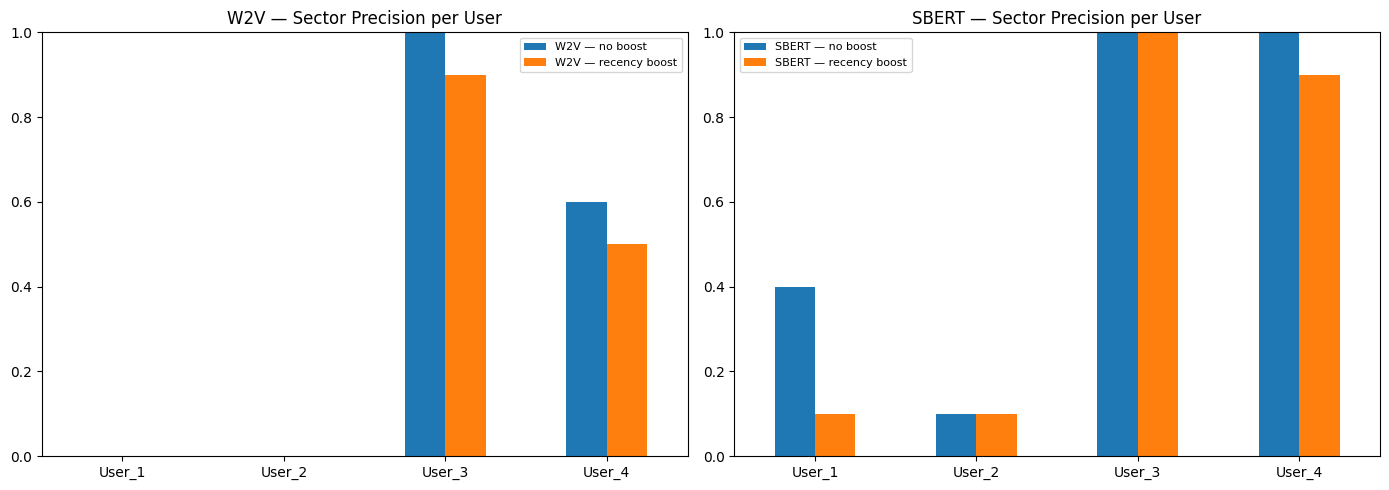

In [13]:
# Sector precision per user — W2V vs SBERT
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, model in [(axes[0], 'W2V'), (axes[1], 'SBERT')]:
    subset = df_eval[df_eval['config'].str.startswith(model)]
    pivot  = subset.pivot(index='user_id', columns='config', values='sector_precision')
    pivot.plot(kind='bar', ax=ax, title=f'{model} — Sector Precision per User', ylim=(0, 1))
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=0)
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

## Step 7 — Save

In [14]:
CONFIG_FILENAMES = {
    'W2V — no boost':        'recs_w2v_no_boost.csv',
    'W2V — recency boost':   'recs_w2v_boost.csv',
    'SBERT — no boost':      'recs_sbert_no_boost.csv',
    'SBERT — recency boost': 'recs_sbert_boost.csv',
}

for config_name, user_recs in all_recs.items():
    frames = []
    for user_id, recs in user_recs.items():
        recs = recs.copy()
        recs.insert(0, 'user_id', user_id)
        frames.append(recs)
    combined = pd.concat(frames, ignore_index=True)
    path = f'../data/processed/recommendations/{CONFIG_FILENAMES[config_name]}'
    combined.to_csv(path, index=False)
    print(f'Saved: {path} ({len(combined)} rows)')

print('\nAll recommendation CSVs saved.')

Saved: ../data/processed/recommendations/recs_w2v_no_boost.csv (40 rows)
Saved: ../data/processed/recommendations/recs_w2v_boost.csv (40 rows)
Saved: ../data/processed/recommendations/recs_sbert_no_boost.csv (40 rows)
Saved: ../data/processed/recommendations/recs_sbert_boost.csv (40 rows)

All recommendation CSVs saved.


## Conclusions
- [ ] W2V no boost — mean sector precision: ...
- [ ] W2V recency boost — mean sector precision: ...
- [ ] SBERT no boost — mean sector precision: ...
- [ ] SBERT recency boost — mean sector precision: ...
- [ ] Best overall config: ...
- [ ] Does recency boost improve results: yes / no / marginally
- [ ] Ready for evaluation notebook (09): yes/no